# starting with the simplest way of mapping to snRNAseq
1. compute the vector of 315 genes, 
2. get cosine similarity on these
3. and rank-based method. 
4. (maybe) CCA based. 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,glob,sys
from pprint import pprint
import scvi
import anndata
import scanpy as sc
from scipy.io import mmread
intersted_genes = ['Trhr','Pdyn','Tacr3','Shox2','Gpr101',]
markergenes = ['Dbh', 'Th', 'Slc6a2']

# load merfish data

In [17]:
filename = '/allen/aind/scratch/shuonan.chen/code/pons_merfish_pipeline/processing/adata_mer_subset_3k.h5ad'
adata_mer = sc.read_h5ad(filename)


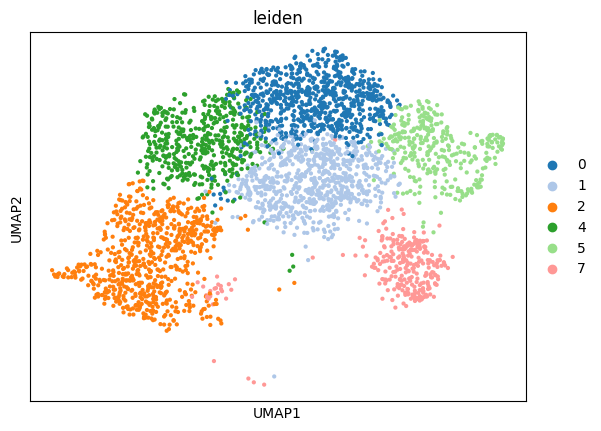

In [18]:
sc.pl.umap(adata_mer, color='leiden')

# load snRNAseq data

In [19]:
filepath = '/allen/aind/scratch/shuonan.chen/LC_scRNAseq/conversion_files/'
f = glob.glob(filepath+'/*.h5ad')[1]
dataname = os.path.basename(f).split('.')[0]
targetfile = filepath + f'{dataname}.h5ad'    
targetfile_raw = filepath + f'RNA_counts_{dataname}.mtx'
adata_sc = sc.read_h5ad(targetfile)
adata_sc.layers['rawcounts'] = mmread(targetfile_raw).transpose().tocsr().astype('float64')    
adata_sc.X = adata_sc.layers['rawcounts']  
adata_sc.obs['sex'] = adata_sc.obs['sex'].replace({'M;M;M;M;M;M;M;M;M;M': 'M', 'F;F;F;F;F;F;F;F;F;F': 'F'})

/scratch/fast/18050/ipykernel_3726341/2949898209.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata_sc.obs['sex'] = adata_sc.obs['sex'].replace({'M;M;M;M;M;M;M;M;M;M': 'M', 'F;F;F;F;F;F;F;F;F;F': 'F'})


# get the expression vector

In [20]:
var_names = adata_mer.var_names.intersection(adata_sc.var_names)
var_names

Index(['8030451A03Rik', '9130024F11Rik', '9630002D21Rik', 'Abca13', 'Abi3bp',
       'Adam33', 'Adamts18', 'Adamts19', 'Adamtsl5', 'Adarb2',
       ...
       'Htr2c', 'Htr2a', 'Kcna1', 'Npy1r', 'Npy2r', 'Npy5r', 'Nr2f2', 'Nr4a2',
       'Pdzrn3', 'Samd3'],
      dtype='object', length=314)

In [21]:
adata_mer[:,var_names]

View of AnnData object with n_obs × n_vars = 3227 × 314
    obs: 'slicename', 'x_CCF', 'y_CCF', 'z_CCF', 'mouse_name', '_scvi_batch', '_scvi_labels', 'leiden', 'n_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'mouse_name_colors', 'neighbors', 'slicename_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [22]:
A = adata_mer.raw.X[:,np.where([q in var_names for q in adata_mer.var_names])[0]]
B = adata_sc[:,var_names].X.toarray()

In [30]:
np.where([q not in var_names for q in adata_mer.var_names])

(array([24]),)

In [31]:
adata_mer.var_names[24] # this is not in snRNAseq?

'C130060K24Rik'

In [36]:
np.unique((adata_mer.var_names)).shape

(315,)

In [38]:
adata_mer.var_names[20:30]

Index(['Asb4', 'Best1', 'Brs3', 'C030005K06Rik', 'C130060K24Rik', 'C1ql3',
       'C7', 'Cacna2d1', 'Calb1', 'Calb2'],
      dtype='object')

## normalized dot product to find the most similar cells..

In [23]:
A.shape, B.shape

((3227, 314), (5040, 314))

In [24]:
norm_dot_prod = np.dot(A, B.T)/(np.sqrt((A**2).sum(axis=1))[:,None]@np.sqrt((B**2).sum(axis=1))[None,:])

In [25]:
np.argmax(norm_dot_prod, 1)

array([3858, 3335, 3858, ..., 3858, 3009, 3009])

In [26]:
adata_sc.obs.iloc[np.argmax(norm_dot_prod, 1)]['seurat_clusters'].values

['5', '5', '5', '5', '5', ..., '5', '5', '5', '6', '6']
Length: 3227
Categories (11, object): ['0', '1', '2', '3', ..., '7', '8', '9', '10']

### check the seurat cluster ID

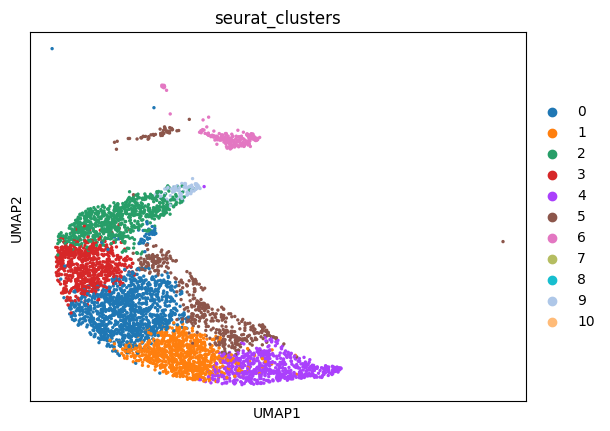

In [27]:
sc.pl.umap(adata_sc, color='seurat_clusters')

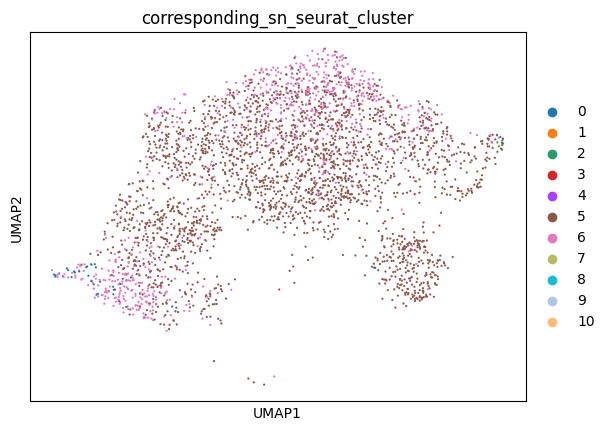

In [28]:
adata_mer.obs['corresponding_sn_seurat_cluster'] = adata_sc.obs.iloc[np.argmax(norm_dot_prod, 1)]['seurat_clusters'].values
sc.pl.umap(adata_mer, color = 'corresponding_sn_seurat_cluster', size = 10)

### check scvi clusters

In [13]:
sc.pp.highly_variable_genes(adata_sc, n_top_genes=1000, flavor="seurat_v3", batch_key="sex")#,flavor='seurat_v3')
sc.pp.pca(adata_sc)

scvi.model.SCVI.setup_anndata(adata_sc, batch_key="sample_name",categorical_covariate_keys = ['sex'])
model = scvi.model.SCVI(adata_sc, n_layers=1, n_latent=10, gene_likelihood="zinb")
model.train()

/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)
/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /allen/aind/scratch/shuonan.chen/conda_envs/torch_on ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/allen/aind/scratch/shuonan.chen/conda_envs/torch_on_gpu_py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` comman

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [14]:
SCVI_LATENT_KEY = "X_scVI"
adata_sc.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata_sc, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata_sc, random_state=210)
sc.tl.leiden(adata_sc, resolution=1) 

/scratch/fast/18050/ipykernel_3726341/3145906190.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_mer, resolution=1)


In [ ]:
sc.pl.umap(
    adata_sc,
    color=["sample_name", "sex", "seurat_clusters"],
    ncols=2,
)

In [ ]:
adata_mer.obs['corresponding_sn_leiden'] = adata_sc.obs.iloc[np.argmax(norm_dot_prod, 1)]['leiden'].values
sc.pl.umap(adata_mer, color = 'corresponding_sn_leiden', size = 10)

In [ ]:
np.unique(adata_mer.obs['corresponding_sn_leiden'], return_counts=True)


**why is it predominated by 12 abd 14?** 
(check whats so special about these clusters)

In [ ]:
de_results = model.differential_expression(
    adata_sc,
    groupby='leiden',
    group1='12',
    mode="change",
    delta=0.5,  # Log fold change threshold
)
de_results_12 = de_results.sort_values('lfc_mean', key=abs, ascending=False)
de_results_12['significant'] = (de_results_12['proba_not_de'] < 0.05) & (abs(de_results_12['lfc_mean']) > 0.5)


In [ ]:
de_results

In [ ]:
de_results = model.differential_expression(
    adata_sc,
    groupby='leiden',
    group1='15',
    mode="change",
    delta=0.5,  # Log fold change threshold
)
de_results_14 = de_results.sort_values('lfc_mean', key=abs, ascending=False)

# Add some useful columns
de_results_14['significant'] = (de_results_14['proba_not_de'] < 0.05) & (abs(de_results_14['lfc_mean']) > 0.5)


In [ ]:
de_results_12['significant'].sum(),de_results_14['significant'].sum()

In [ ]:
set1 = set(de_results_11[de_results_12['significant']].index)
set2 = set(de_results_15[de_results_14['significant']].index)
[m in (list(set1.intersection(set2))) for m in intersted_genes]

In [ ]:
adata_sc.raw=adata_sc
sc.pp.log1p(adata_sc)

In [ ]:
sc.tl.rank_genes_groups(adata_sc, groupby='leiden', groups=['12','14'], reference='rest',method='wilcoxon')
sc.pl.rank_genes_groups(adata_sc, n_genes=25, sharey=False)



In [ ]:
# Check expression of known markers
sc.pl.violin(adata_mer, ['Dbh','Th','Slc6a2'], groupby='leiden')

In [ ]:
# Check expression of known markers
sc.pl.violin(adata_mer, intersted_genes, groupby='leiden')

# rank-based correlation

In [274]:
from scipy.stats import rankdata
def rank_correlation_matrix(X, Y):
    #Calculate Spearman rank correlation between rows of two matrices. 
    # input (N1 x D) and (N2 x D)
    X_ranked = np.apply_along_axis(rankdata, 1, X)
    Y_ranked = np.apply_along_axis(rankdata, 1, Y)
    
    X_centered = X_ranked - (X.shape[1] + 1) / 2
    Y_centered = Y_ranked - (Y.shape[1] + 1) / 2
    n = X.shape[1]
    std = np.sqrt((n**3 - n) / 12)
    out = (X_centered @ Y_centered.T) / (std * std)    
    return out

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [275]:
rank_corr = rank_correlation_matrix(A,B)


In [276]:
rank_corr.max()

np.float64(0.5056305422394839)

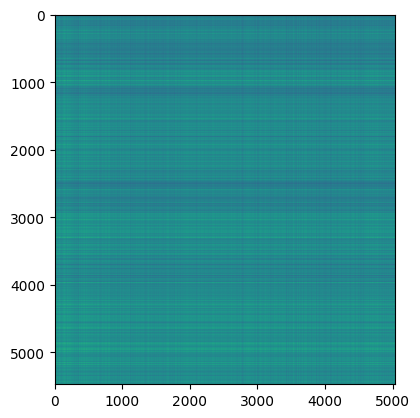

In [277]:
plt.imshow(rank_corr)

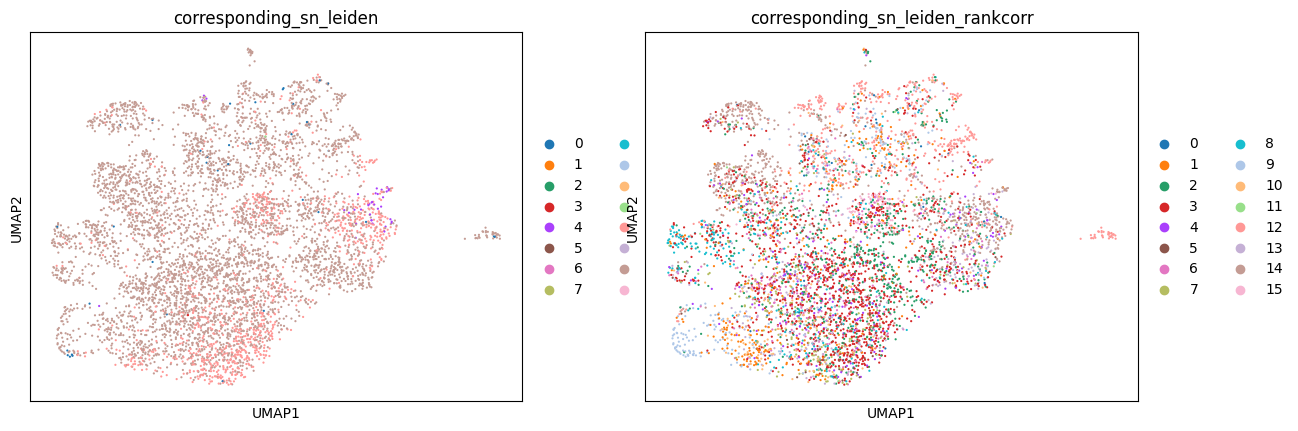

In [278]:
adata_mer.obs['corresponding_sn_leiden_rankcorr'] = adata_sc.obs.iloc[np.argmax(rank_corr, 1)]['leiden'].values
sc.pl.umap(adata_mer, color = ['corresponding_sn_leiden','corresponding_sn_leiden_rankcorr'], size = 10)